In [1]:
"""
Read VIIRS active fire geolocated fire pixels output from XXviirs_access-swath.ipynb
Author: maxwell.cook@colorado.edu
"""

# Import packages
import sys, os
import xarray as xr
import pyproj
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio as rio

from netCDF4 import Dataset # to open NetCDF
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from affine import Affine
from osgeo import gdal, gdal_array, gdalconst, osr
from rasterio.transform import from_bounds
from scipy.spatial import cKDTree
from rasterio.features import rasterize
from tqdm import tqdm

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
# Output directories
dataraw = os.path.join(projdir,'data/spatial/raw/VIIRS/')
datamod = os.path.join(projdir,'data/spatial/mod/VIIRS/')

# File path information
print("Ready !")

Ready !


In [ ]:
# Load and tidy the fire perimeter data

In [2]:
fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
fires = gpd.read_file(fp)

# subset to Southern Rockies
fires = fires[fires['na_l3name'] == 'Southern Rockies']

# tidy the fire id and name columns
fires.rename(columns={'NIFC_ID': 'Fire_ID', 'NIFC_NAME': 'Fire_Name'}, inplace=True)

# tidy the date columns
fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE'])
fires['WF_CESSATION_DATE'] = pd.to_datetime(fires['WF_CESSATION_DATE'])
fires['NIFC_ACRES'] = fires['NIFC_ACRES'].astype(float)

print(f"There are {len(fires)} with > 1% aspen cover in the Southern Rockies (2018-2023)")

There are 67 with > 1% aspen cover in the Southern Rockies (2018-2023)


In [3]:
# Add a 3km buffer to wildfire perimeters
buffer_dist = 3000  # meters
fires = fires.copy() # make a copy of the original data
fires['geometry'] = fires['geometry'].buffer(buffer_dist)
print(f"Buffered fire perimeters by {buffer_dist} meters.")

Buffered fire perimeters by 3000 meters.


In [ ]:
# Create spatial points from lat/lon

In [4]:
fp = os.path.join(datamod,'vnp14img_geo_aspen-fires-srm_2018to2023.csv')
afds = pd.read_csv(fp).reset_index(drop=True)
afds = afds.loc[:, ~afds.columns.str.startswith('Unnamed:')]
print(len(afds))
afds.dtypes

81574


longitude      float64
latitude       float64
fire_mask        int64
confidence      object
daynight        object
acq_date        object
acq_time         int64
granule_id      object
geo_id          object
frp            float64
iot4           float64
iot5           float64
sample           int64
along_scan     float64
along_track    float64
scan_angle     float64
pix_area       float64
dtype: object

In [5]:
afds['acq_date'] = pd.to_datetime(afds['acq_date']) # convert to simple date format
afds['acq_date'].head(3)

0   2018-06-01
1   2018-06-01
2   2018-06-01
Name: acq_date, dtype: datetime64[ns]

In [6]:
# get a summary of fire detection confidence
afds['confidence'].value_counts()

confidence
n    67638
h     8219
l     5717
Name: count, dtype: int64

In [7]:
# drop low confidence detections
N= len(afds)
afds = afds[afds['confidence'] != 'l']
print(f"Dropped [{N-len(afds)}] low-confidence obs.")

Dropped [5717] low-confidence obs.


In [8]:
from shapely.geometry import Point

# convert to spatial points using pixel centroid
afds['geometry'] = [Point(xy) for xy in zip(afds.longitude, afds.latitude)]
afds_ll = gpd.GeoDataFrame(afds, geometry='geometry', crs="EPSG:4326")
afds_ll = afds_ll.to_crs("EPSG:5070")
afds_ll = afds_ll.reset_index(drop=True)
afds_ll['afdID'] = afds_ll.index # add a unique ID
print(afds_ll.head())

# save this file out.
out_fp = os.path.join(datamod,'vnp14img_geo_srm_pix_latlon.gpkg')
afds_ll.to_file(out_fp)
print(f"\nSaved spatial points to: {out_fp}")

   longitude   latitude  fire_mask confidence daynight   acq_date  acq_time  \
0 -104.60649  38.234726          8          n    Night 2018-06-01       824   
1 -104.60698  38.232952          8          n    Night 2018-06-01       824   
2 -104.95000  36.581818          8          n    Night 2018-06-01       824   
3 -104.94370  36.581154          8          n    Night 2018-06-01       824   
4 -104.99421  36.582436          8          n    Night 2018-06-01       824   

                                    granule_id                  geo_id  \
0  VNP14IMG.A2018152.0824.002.2024080110710.nc  VNP03IMG.A2018152.0824   
1  VNP14IMG.A2018152.0824.002.2024080110710.nc  VNP03IMG.A2018152.0824   
2  VNP14IMG.A2018152.0824.002.2024080110710.nc  VNP03IMG.A2018152.0824   
3  VNP14IMG.A2018152.0824.002.2024080110710.nc  VNP03IMG.A2018152.0824   
4  VNP14IMG.A2018152.0824.002.2024080110710.nc  VNP03IMG.A2018152.0824   

        frp        iot4        iot5  sample  along_scan  along_track  \
0  1.722

In [9]:
# join to the fire perimeters
fires_ = fires[['Fire_ID','Fire_Name','START_YEAR','DISCOVERY_DATE','WF_CESSATION_DATE','geometry']]
afds_ll_ = gpd.sjoin(afds_ll, fires_, how='inner', predicate='within')
afds_ll_.drop(columns=['index_right'], inplace=True)

# check for duplicates
dups = afds_ll_[afds_ll_.duplicated(subset='afdID', keep=False)]
print(f"[{len(dups)}/{len(afds_ll)} duplicate obs.")

dups[['afdID','Fire_Name','START_YEAR','acq_date']].head()

del afds_ll
gc.collect()

[4466/75857 duplicate obs.


0

In [10]:
# temporal filters to handle duplicates between fires
afds_ll_f = afds_ll_.copy()

afds_ll_f['acq_date'] = pd.to_datetime(afds_ll_f['acq_date'])
afds_ll_f['acq_month'] = afds_ll_f['acq_date'].dt.month.astype(int)
afds_ll_f['acq_year'] = afds_ll_f['acq_date'].dt.year.astype(int)

afds_ll_f = afds_ll_f[
    (afds_ll_f['acq_date'] >= afds_ll_f['DISCOVERY_DATE'] - timedelta(days=14)) &
    (afds_ll_f['acq_date'] <= afds_ll_f['WF_CESSATION_DATE'] + timedelta(days=14))
]

dups = afds_ll_f[afds_ll_f.duplicated(subset='afdID', keep=False)]
print(f"[{len(dups)}/{len(afds_ll_f)} duplicate obs.")

del afds_ll_
gc.collect()

[0/59631 duplicate obs.


41

In [11]:
afds_ll_f.columns

Index(['longitude', 'latitude', 'fire_mask', 'confidence', 'daynight',
       'acq_date', 'acq_time', 'granule_id', 'geo_id', 'frp', 'iot4', 'iot5',
       'sample', 'along_scan', 'along_track', 'scan_angle', 'pix_area',
       'geometry', 'afdID', 'Fire_ID', 'Fire_Name', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'acq_month', 'acq_year'],
      dtype='object')

In [12]:
# grab a count of observations for each fire
counts = afds_ll_f.groupby(['Fire_ID']).size().reset_index(name='obs_count')
afds_ll_f = pd.merge(afds_ll_f, counts, left_on='Fire_ID', right_on='Fire_ID', how='left')
afds_ll_f['obs_count'].describe()

count    59631.000000
mean      6161.850296
std       4287.809334
min          1.000000
25%       2116.000000
50%       8734.000000
75%       9370.000000
max      11916.000000
Name: obs_count, dtype: float64

In [13]:
# filter to retain fires with at least N observations
n_obs = 10
afds_ll_f = afds_ll_f[afds_ll_f['obs_count'] >= n_obs]
print(f"There are {len(afds_ll_f['Fire_ID'].unique())} fires with >= {n_obs} obs.")

There are 50 fires with >= 10 obs.


In [14]:
fires_ = fires[fires['Fire_ID'].isin(afds_ll_f['Fire_ID'].unique())]
len(fires_)

50

In [15]:
# save this file out.
out_fp = os.path.join(datamod,'vnp14img_geo_srm_pix_latlon_aspenfires.gpkg')
afds_ll_f.to_file(out_fp)
print(f"Saved spatial points to: {out_fp}")

Saved spatial points to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/vnp14img_geo_srm_pix_latlon_aspenfires.gpkg


In [ ]:
# Create the ground area of pixels

In [16]:
# Define the pixel buffer function for the given width and height
def pixel_area(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

afds_ll_pix = afds_ll_f.copy()

# Apply the buffer function with along_scan and along_track values converted to meters (*1000)
afds_ll_pix["geometry"] = afds_ll_pix.apply(
    lambda row: pixel_area(row["geometry"], row["along_scan"] * 1000, row["along_track"] * 1000), axis=1
)

afds_ll_pix = afds_ll_pix.reset_index(drop=True)
afds_ll_pix['obs_id'] = afds_ll_pix.index # unique ID column

afds_ll_pix.head() # check the results

,longitude,latitude,fire_mask,confidence,daynight,acq_date,acq_time,granule_id,geo_id,frp,...,afdID,Fire_ID,Fire_Name,START_YEAR,DISCOVERY_DATE,WF_CESSATION_DATE,acq_month,acq_year,obs_count,obs_id
0,-107.809900,37.458965,8,n,Day,2018-06-01,1948,VNP14IMG.A2018152.1948.002.2024080110709.nc,VNP03IMG.A2018152.1948,7.603679,...,404,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,6,2018,2906,0
1,-107.810940,37.462734,9,h,Day,2018-06-01,1948,VNP14IMG.A2018152.1948.002.2024080110709.nc,VNP03IMG.A2018152.1948,48.685238,...,405,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,6,2018,2906,1
2,-107.820670,37.460793,8,n,Day,2018-06-01,1948,VNP14IMG.A2018152.1948.002.2024080110709.nc,VNP03IMG.A2018152.1948,25.084015,...,406,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,6,2018,2906,2
3,-107.816840,37.465534,9,h,Day,2018-06-01,1948,VNP14IMG.A2018152.1948.002.2024080110709.nc,VNP03IMG.A2018152.1948,48.685238,...,407,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,6,2018,2906,3
4,-107.821754,37.464558,8,n,Day,2018-06-01,1948,VNP14IMG.A2018152.1948.002.2024080110709.nc,VNP03IMG.A2018152.1948,25.084015,...,408,14,416,2018,2018-06-01 11:02:00,2018-07-03 18:00:00,6,2018,2906,4


In [17]:
# save this file out.
out_fp = os.path.join(datamod,'vnp14img_geo_srm_pix_area_aspenfires.gpkg')
afds_ll_pix.to_file(out_fp)
print(f"Saved to {out_fp}\n")

Saved to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/vnp14img_geo_srm_pix_area_aspenfires.gpkg



In [18]:
len(afds_ll_pix)

59582

In [19]:
afds_ll_pix.columns

Index(['longitude', 'latitude', 'fire_mask', 'confidence', 'daynight',
       'acq_date', 'acq_time', 'granule_id', 'geo_id', 'frp', 'iot4', 'iot5',
       'sample', 'along_scan', 'along_track', 'scan_angle', 'pix_area',
       'geometry', 'afdID', 'Fire_ID', 'Fire_Name', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'acq_month', 'acq_year',
       'obs_count', 'obs_id'],
      dtype='object')

In [20]:
afds_ll_pix['acq_datetime'] = afds_ll_pix.apply(
    lambda row: convert_datetime(row['acq_date'], row['acq_time'], zone='America/Denver'), 
    axis=1
)
afds_ll_pix[['acq_date','acq_time','acq_datetime','daynight']].head()

,acq_date,acq_time,acq_datetime,daynight
0,2018-06-01,1948,2018-06-01 13:48:00-06:00,Day
1,2018-06-01,1948,2018-06-01 13:48:00-06:00,Day
2,2018-06-01,1948,2018-06-01 13:48:00-06:00,Day
3,2018-06-01,1948,2018-06-01 13:48:00-06:00,Day
4,2018-06-01,1948,2018-06-01 13:48:00-06:00,Day


In [21]:
# check on nighttime datetimes
day_obs = afds_ll_pix[afds_ll_pix['daynight'] == 'Day']
day_obs['acq_time_mst'] = day_obs['acq_datetime'].dt.time

print(f"Minimum MST datetime for 'Day': {day_obs['acq_time_mst'].min()}")
print(f"Maximum MST datetime for 'Day': {day_obs['acq_time_mst'].max()}")
del day_obs

Minimum MST datetime for 'Day': 12:42:00
Maximum MST datetime for 'Day': 15:12:00


In [22]:
# check on nighttime datetimes
night_obs = afds_ll_pix[afds_ll_pix['daynight'] == 'Night']
night_obs['acq_time_mst'] = night_obs['acq_datetime'].dt.time

print(f"Minimum MST datetime for 'Night': {night_obs['acq_time_mst'].min()}")
print(f"Maximum MST datetime for 'Night': {night_obs['acq_time_mst'].max()}")
del night_obs

Minimum MST datetime for 'Night': 01:06:00
Maximum MST datetime for 'Night': 04:18:00


In [ ]:
# Handle duplicate observations for AFDs

In [23]:
# Spatial overlap > 30% and the same acquisition date and time

# Find duplicates in space and time
drop_obs = set() # to store the observations we want to drop
overlap_threshold = 0.30 # spatial overlap (percent)

# group the observations by datetime
dt_groups = afds_ll_pix.groupby(['Fire_ID','acq_datetime'])
print(f"Number of unique (Fire_ID, acq_datetime) groups: {len(dt_groups)}")

def process_group(group):
    drop_obs = set()

    # spatial index
    sidx = group.sindex

    for idx, obs in group.iterrows():
        if obs['afdID'] in drop_obs:
            continue  # Skip if already marked

        # Find overlapping geometries within the group
        overlap_idxs = list(sidx.intersection(obs.geometry.bounds))
        overlap_obs = group.iloc[overlap_idxs]

        for match_idx, match_obs in overlap_obs.iterrows():
            if match_obs['afdID'] == obs['afdID'] or match_obs['afdID'] in drop_obs:
                continue  # Skip self-comparisons or already processed

            # Calculate intersection and overlap ratio
            area = obs.geometry.intersection(match_obs.geometry).area
            ratio = area / obs.geometry.area

            # Check for spatial overlap > threshold
            if ratio > overlap_threshold:
                if match_obs['frp'] < obs['frp']:
                    drop_obs.add(match_obs['afdID'])
                else:
                    drop_obs.add(obs['afdID'])
                    break  # No need to check further for this observation

    return drop_obs

# Process observations grouped by Fire_ID and acq_datetime
for (fire_id, datetime), group in dt_groups:
    if len(group) > 1:  # Only process groups with potential duplicates
        drop_obs.update(process_group(group))

# apply to the AFD ground area data
print(f"Identified a total of [{len(drop_obs)}/{len(afds_ll_pix)}] duplicate observations.")
afds_ll_pix_ = afds_ll_pix[~afds_ll_pix['afdID'].isin(drop_obs)] # drop the duplicate obs.

del afds_ll_pix
gc.collect()

Number of unique (Fire_ID, acq_datetime) groups: 1682
Identified a total of [7545/59582] duplicate observations.


0

In [24]:
# save this file out.
out_fp = os.path.join(datamod, 'vnp14img_geo_srm_pix_area_aspenfires_.gpkg')
afds_ll_pix_.to_file(out_fp)
print(f"Saved to:{out_fp}")

Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/vnp14img_geo_srm_pix_area_aspenfires_.gpkg


In [25]:
# save a version for GEE
afds_ll_pix_gee = afds_ll_pix_.copy()

afds_ll_pix_gee.rename(columns={'DISCOVERY_DATE': 'Ig_Date', 'WF_CESSATION_DATE': 'Last_Date'}, inplace=True)
afds_ll_pix_gee = afds_ll_pix_gee[['afdID','acq_date','daynight','Fire_ID','Ig_Date','Last_Date','geometry']]
afds_ll_pix_gee['acq_date'] = afds_ll_pix_gee['acq_date'].dt.date.astype(str)
afds_ll_pix_gee['Ig_Date'] = afds_ll_pix_gee['Ig_Date'].dt.date.astype(str)
afds_ll_pix_gee['Last_Date'] = afds_ll_pix_gee['Last_Date'].dt.date.astype(str)

print(afds_ll_pix_gee.dtypes)

out_fp = os.path.join(projdir, 'data/earth-engine/imports/vnp14img_geo_srm_pix_area_aspenfires.shp')
afds_ll_pix_gee.to_file(out_fp)
print(f"Saved to:{out_fp}")

del afds_ll_pix_gee

afdID           int64
acq_date       object
daynight       object
Fire_ID        object
Ig_Date        object
Last_Date      object
geometry     geometry
dtype: object
Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/vnp14img_geo_srm_pix_area_aspenfires.shp


In [26]:
# also save a fire perimeter dataset for GEE
fires_ = fires[fires['Fire_ID'].isin(afds_ll_pix_['Fire_ID'])]
fires_ = fires_[['Fire_ID','Fire_Name','START_YEAR','DISCOVERY_DATE','WF_CESSATION_DATE','geometry']]
fires_.rename(columns={'START_YEAR': 'Fire_Year', 'DISCOVERY_DATE': 'Ig_Date', 'WF_CESSATION_DATE': 'Last_Date'}, inplace=True)
fires_['Ig_Date'] = fires_['Ig_Date'].dt.date.astype(str)
fires_['Last_Date'] = fires_['Last_Date'].dt.date.astype(str)

out_fp = os.path.join(projdir, 'data/earth-engine/imports/nifc_aspenfires_2018to2023.shp')
fires_.to_file(out_fp)

print(fires_.head())

print(f"\nSaved to:{out_fp}")

  Fire_ID       Fire_Name Fire_Year     Ig_Date   Last_Date  \
2      14             416      2018  2018-06-01  2018-07-03   
4      24         PLATEAU      2018  2018-07-22  2018-08-17   
5      26         PLUMTAW      2022  2022-05-17  2022-05-18   
6      33      DOE CANYON      2019  2019-06-20  2019-07-03   
7      43  CHRIS MOUNTAIN      2023  2023-06-28  2023-07-04   

                                            geometry  
2  POLYGON ((-1049979.478 1675062.140, -1049943.6...  
4  POLYGON ((-1097425.258 1687412.458, -1097411.7...  
5  POLYGON ((-972808.959 1648515.784, -972812.086...  
6  POLYGON ((-1107281.763 1705185.622, -1107310.1...  
7  POLYGON ((-987311.103 1642200.746, -987297.034...  

Saved to:/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/earth-engine/imports/nifc_aspenfires_2018to2023.shp


In [27]:
# create a regular grid extracted to fire perimeters
def regular_grid(extent, res=0.0035, crs_out='EPSG:5070', regions=None):
    """
    Creates a regular-spaced grid
    """
    # retrieve bounding coordinates
    min_lon, max_lon, min_lat, max_lat = extent
    
    # create the grid lines in degrees
    x_coords = np.arange(min_lon, max_lon, res)
    y_coords = np.arange(min_lat, max_lat, res)

    # generate the grid cells
    cells = [
        Polygon([(x, y), (x + res, y), (x + res, y + res), (x, y + res)])
        for x in x_coords for y in y_coords
    ]

    # create a geodataframe in WGS, reprojected if needed
    grid = gpd.GeoDataFrame({'geometry': cells}, crs=crs_out)

    if regions is not None:
        if regions.crs != grid.crs:
            regions = regions.to_crs(grid.crs)
        # Perform spatial intersection to keep only grid cells overlapping the polygon
        grid = grid[grid.intersects(regions.unary_union)].copy()

    return grid
    

# generate the grid
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
srm = ecol3[ecol3['NA_L3NAME'] == 'Southern Rockies']

# get the SRM extent in lat/lon (WGS)
coords, extent = get_coords(srm, buffer=3000, crs='EPSG:5070')
print(f"Bounding extent for the SRM: {extent}")

# generate the grid (0.0039 degrees or 375m)
grid = regular_grid(extent, res=375, crs_out='EPSG:5070', regions=fires_)

# save this out.
out_fp = os.path.join(projdir, 'data/spatial/mod/srm_fires_grid_375m.gpkg')
grid.to_file(out_fp, driver="GPKG")
print(f"Grid saved to: {out_fp}")

Bounding extent for the SRM: [-1184484.4171543047, -689479.4244799014, 1397166.4988387332, 2246127.1529145916]
Grid saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fires_grid_375m.gpkg


In [ ]:
# calculate a gridded cumulative FRP and maximum FRP

In [28]:
# process the fire data
t0 = time.time()

def aggregate_frp(detections, grid):
    """
    Aggregate fire pixel data into a regular grid using vector overlay.
    """
    grid = grid.reset_index(drop=False).rename(columns={'index': 'grid_index'})
    grid['grid_area'] = grid.geometry.area  # precompute grid cell areas
    
    print(f"Aggregating {len(detections)} detections.")
    if detections.crs != grid.crs:
        detections = detections.to_crs(grid.crs)

    detections['pix_area_m2'] = detections['pix_area'] * 1e6
    
    # identify the overlaps
    overlay = gpd.overlay(detections, grid, how='intersection')
    print(f"Number of matches: {len(overlay)}")

    # compute fractional overlap area
    overlay['overlap_area'] = overlay.geometry.area
    overlay['fraction'] = overlay['overlap_area'] / overlay['pix_area_m2']

    # scale FRP by area
    overlay['frp_sc'] = overlay['frp'] * overlay['fraction']
    print(overlay[['grid_index','obs_id','frp','fraction','frp_sc']].head(10))
    
    # Aggregate by grid cell
    aggregated = overlay.groupby('grid_index').agg(
        frp_cumsum=('frp_sc', 'sum'),
        frp_max=('frp_sc', 'max'),
        doy_max_frp=('acq_date', lambda x: x.iloc[np.argmax(x)]),
    ).reset_index()
    print(f"Number of grid cells with aggregated data: {len(aggregated)}")
    print(aggregated.head())

    # Join results back to grid
    grid = grid.merge(aggregated, on='grid_index', how='right')

    # Fill NaN values with 0 for the aggregated columns
    grid[['frp_cumsum', 'frp_max', 'doy_max_frp']] = grid[
        ['frp_cumsum', 'frp_max', 'doy_max_frp']
    ].fillna(0)

    return grid


# Initialize results list
fire_grids = []
for _, fire in fires_[0:1].iterrows():
    t1 = time.time()
    
    fire_gdf = gpd.GeoDataFrame([fire], crs=fires_.crs)  # Ensure GeoDataFrame
    
    # aggregate fire pixels to the grid
    fire_grid = aggregate_frp(afds_ll_pix_[afds_ll_pix_['Fire_ID'] == fire['Fire_ID']], grid)
    fire_grids.append(fire_grid)

    t2 = (time.time() - t1) / 60
    print(f"\tTime to complete fire {fire['Fire_Name']}: {t2:.2f} minutes.\n")

# Combine all grids into one
fire_data = pd.concat(fire_grids)

t3 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t3:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

Aggregating 2492 detections.
Number of matches: 13157
   grid_index  obs_id        frp  fraction     frp_sc
0      917637       0   7.603679  0.145140   1.103599
1      917638       0   7.603679  0.125444   0.953838
2      919901       0   7.603679  0.385942   2.934582
3      919902       0   7.603679  0.333569   2.536352
4      922165       0   7.603679  0.005313   0.040395
5      922166       0   7.603679  0.004592   0.034913
6      917638       1  48.685238  0.138474   6.741657
7      917639       1  48.685238  0.205137   9.987130
8      919902       1  48.685238  0.264523  12.878366
9      919903       1  48.685238  0.391866  19.078086
Number of grid cells with aggregated data: 1889
   grid_index  frp_cumsum   frp_max doy_max_frp
0      822559    0.013384  0.013384  2018-07-05
1      822560    0.301194  0.301194  2018-07-05
2      822561    0.230308  0.230308  2018-07-05
3      824823    0.146238  0.146238  2018-07-05
4      824824    3.290989  3.290989  2018-07-05
	Time to complet

In [29]:
fire_data.head()

,grid_index,geometry,grid_area,frp_cumsum,frp_max,doy_max_frp
0,822559,"POLYGON ((-1048359.417 1669791.499, -1047984.4...",140625.0,0.013384,0.013384,2018-07-05
1,822560,"POLYGON ((-1048359.417 1670166.499, -1047984.4...",140625.0,0.301194,0.301194,2018-07-05
2,822561,"POLYGON ((-1048359.417 1670541.499, -1047984.4...",140625.0,0.230308,0.230308,2018-07-05
3,824823,"POLYGON ((-1047984.417 1669791.499, -1047609.4...",140625.0,0.146238,0.146238,2018-07-05
4,824824,"POLYGON ((-1047984.417 1670166.499, -1047609.4...",140625.0,3.290989,3.290989,2018-07-05


In [30]:
fire_data.isna().sum()

grid_index     0
geometry       0
grid_area      0
frp_cumsum     0
frp_max        0
doy_max_frp    0
dtype: int64

In [31]:
fire_data['frp_cumsum'].max()

377.39685275659673

In [32]:
fire_data['doy_max_frp'] = fire_data['doy_max_frp'].astype(str)
fire_data.to_file(os.path.join(datamod,'testing_grid_aggregation.gpkg'))

In [ ]:
# Compare with non-geolocated data

In [44]:
fire416 = fires_[fires_['Fire_Name'] == '416']
len(fire416)

1

In [45]:
afds416 = os.path.join(datamod,'afds_testing_416.csv')
afds416 = pd.read_csv(afds416)
print(len(afds416))
afds416.head()

61124


,Unnamed: 0,longitude,latitude,fire_mask,confidence,frp,acq_date,acq_time,daynight,satellite,short_name,granule_id,geo_id,sample,along_scan,along_track,scan_angle,pix_area
0,0,-81.789650,29.157127,7,l,8.717953,6/1/2018,1854,Day,JPSS-1,VJ114IMG,VJ114IMG.A2018152.1854.002.2024007123441.nc,VJ103IMG.A2018152.1854.021.2021041034844.nc,1992,0.386993,0.436507,32.0140,0.168925
1,1,-92.443000,27.546436,8,n,4.332225,6/1/2018,1854,Day,JPSS-1,VJ114IMG,VJ114IMG.A2018152.1854.002.2024007123441.nc,VJ103IMG.A2018152.1854.021.2021041034844.nc,4388,0.383294,0.434600,31.6760,0.166580
2,2,-82.821520,29.951992,8,n,4.513534,6/1/2018,1854,Day,JPSS-1,VJ114IMG,VJ114IMG.A2018152.1854.002.2024007123441.nc,VJ103IMG.A2018152.1854.021.2021041034844.nc,2146,0.524168,0.416594,28.1189,0.218365
3,3,-82.972664,30.057590,8,n,5.128933,6/1/2018,1854,Day,JPSS-1,VJ114IMG,VJ114IMG.A2018152.1854.002.2024007123441.nc,VJ103IMG.A2018152.1854.021.2021041034844.nc,2169,0.516652,0.413837,27.5053,0.213810
4,4,-82.973250,30.061384,8,n,12.627224,6/1/2018,1854,Day,JPSS-1,VJ114IMG,VJ114IMG.A2018152.1854.002.2024007123441.nc,VJ103IMG.A2018152.1854.021.2021041034844.nc,2169,0.516652,0.413837,27.5053,0.213810


In [46]:
afds416 = afds416[afds416['short_name'] == 'VNP14IMG']
len(afds416)

30942

In [47]:
# drop low confidence detections
N= len(afds416)
afds416 = afds416[afds416['confidence'] != 'l']
print(f"Dropped [{N-len(afds416)}] low-confidence obs.")

Dropped [2305] low-confidence obs.


In [48]:
from shapely.geometry import Point

# convert to spatial points using pixel centroid
afds416['geometry'] = [Point(xy) for xy in zip(afds416.longitude, afds416.latitude)]
afds_ll416 = gpd.GeoDataFrame(afds416, geometry='geometry', crs="EPSG:4326")
afds_ll416 = afds_ll416.to_crs("EPSG:5070")
afds_ll416 = afds_ll416.reset_index(drop=True)
afds_ll416['afdID'] = afds_ll416.index # add a unique ID
print(afds_ll416.head())

afds_ll416 = gpd.sjoin(afds_ll416, fire416, how='inner', predicate='within')
afds_ll416.drop(columns=['index_right'], inplace=True)
print(len(afds_ll416))

   Unnamed: 0  longitude   latitude  fire_mask confidence         frp  \
0         332  -92.08672  37.668890          8          n    2.578065   
1         333 -108.65426  35.555725          8          n    5.624754   
2         335 -104.98010  36.500410          9          h   79.036330   
3         337 -104.96744  36.506233          9          h  140.050020   
4         338 -104.97194  36.505440          9          h   73.050160   

   acq_date  acq_time daynight  satellite short_name  \
0  6/1/2018      1948      Day  SUOMI-NPP   VNP14IMG   
1  6/1/2018      1948      Day  SUOMI-NPP   VNP14IMG   
2  6/1/2018      1948      Day  SUOMI-NPP   VNP14IMG   
3  6/1/2018      1948      Day  SUOMI-NPP   VNP14IMG   
4  6/1/2018      1948      Day  SUOMI-NPP   VNP14IMG   

                                    granule_id  \
0  VNP14IMG.A2018152.1948.002.2024080110709.nc   
1  VNP14IMG.A2018152.1948.002.2024080110709.nc   
2  VNP14IMG.A2018152.1948.002.2024080110709.nc   
3  VNP14IMG.A2018152.194

In [39]:
afds_ll416.to_file(os.path.join(datamod,'afds_testing_416.gpkg'))

In [49]:
# Define the pixel buffer function for the given width and height
def pixel_area(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

afds_ll_pix416 = afds_ll416.copy()

# Apply the buffer function with along_scan and along_track values converted to meters (*1000)
afds_ll_pix416["geometry"] = afds_ll_pix416.apply(
    lambda row: pixel_area(row["geometry"], row["along_scan"] * 1000, row["along_track"] * 1000), axis=1
)

afds_ll_pix416 = afds_ll_pix416.reset_index(drop=True)
afds_ll_pix416['obs_id'] = afds_ll_pix416.index # unique ID column

afds_ll_pix416.head() # check the results

,Unnamed: 0,longitude,latitude,fire_mask,confidence,frp,acq_date,acq_time,daynight,satellite,...,scan_angle,pix_area,geometry,afdID,Fire_ID,Fire_Name,Fire_Year,Ig_Date,Last_Date,obs_id
0,478,-107.809900,37.458965,8,n,7.603679,6/1/2018,1948,Day,SUOMI-NPP,...,27.8788,0.216555,"POLYGON ((-1031854.255 1666193.625, -1031854.2...",81,14,416,2018,2018-06-01,2018-07-03,0
1,479,-107.810940,37.462734,9,h,48.685238,6/1/2018,1948,Day,SUOMI-NPP,...,27.8788,0.216555,"POLYGON ((-1031892.316 1666624.052, -1031892.3...",82,14,416,2018,2018-06-01,2018-07-03,1
2,480,-107.820670,37.460793,8,n,25.084015,6/1/2018,1948,Day,SUOMI-NPP,...,27.9322,0.216954,"POLYGON ((-1032764.880 1666513.807, -1032764.8...",83,14,416,2018,2018-06-01,2018-07-03,2
3,482,-107.816840,37.465534,9,h,48.685238,6/1/2018,1948,Day,SUOMI-NPP,...,27.9055,0.216755,"POLYGON ((-1032366.169 1666999.460, -1032366.1...",84,14,416,2018,2018-06-01,2018-07-03,3
4,483,-107.821754,37.464558,8,n,25.084015,6/1/2018,1948,Day,SUOMI-NPP,...,27.9322,0.216954,"POLYGON ((-1032806.771 1666944.272, -1032806.7...",85,14,416,2018,2018-06-01,2018-07-03,4


In [50]:
afds_ll_pix416['acq_datetime'] = afds_ll_pix416.apply(
    lambda row: convert_datetime(row['acq_date'], row['acq_time'], zone='America/Denver'), 
    axis=1
)
afds_ll_pix416[['acq_date','acq_time','acq_datetime','daynight']].head()

,acq_date,acq_time,acq_datetime,daynight
0,6/1/2018,1948,2018-06-01 13:48:00-06:00,Day
1,6/1/2018,1948,2018-06-01 13:48:00-06:00,Day
2,6/1/2018,1948,2018-06-01 13:48:00-06:00,Day
3,6/1/2018,1948,2018-06-01 13:48:00-06:00,Day
4,6/1/2018,1948,2018-06-01 13:48:00-06:00,Day


In [51]:
afds_ll_pix416.columns

Index(['Unnamed: 0', 'longitude', 'latitude', 'fire_mask', 'confidence', 'frp',
       'acq_date', 'acq_time', 'daynight', 'satellite', 'short_name',
       'granule_id', 'geo_id', 'sample', 'along_scan', 'along_track',
       'scan_angle', 'pix_area', 'geometry', 'afdID', 'Fire_ID', 'Fire_Name',
       'Fire_Year', 'Ig_Date', 'Last_Date', 'obs_id', 'acq_datetime'],
      dtype='object')

In [52]:
# Spatial overlap > 30% and the same acquisition date and time

# Find duplicates in space and time
drop_obs = set() # to store the observations we want to drop
overlap_threshold = 0.30 # spatial overlap (percent)

# group the observations by datetime
dt_groups = afds_ll_pix416.groupby(['Fire_ID','acq_datetime'])
print(f"Number of unique (Fire_ID, acq_datetime) groups: {len(dt_groups)}")

def process_group(group):
    drop_obs = set()

    # spatial index
    sidx = group.sindex

    for idx, obs in group.iterrows():
        if obs['afdID'] in drop_obs:
            continue  # Skip if already marked

        # Find overlapping geometries within the group
        overlap_idxs = list(sidx.intersection(obs.geometry.bounds))
        overlap_obs = group.iloc[overlap_idxs]

        for match_idx, match_obs in overlap_obs.iterrows():
            if match_obs['afdID'] == obs['afdID'] or match_obs['afdID'] in drop_obs:
                continue  # Skip self-comparisons or already processed

            # Calculate intersection and overlap ratio
            area = obs.geometry.intersection(match_obs.geometry).area
            ratio = area / obs.geometry.area

            # Check for spatial overlap > threshold
            if ratio > overlap_threshold:
                if match_obs['frp'] < obs['frp']:
                    drop_obs.add(match_obs['afdID'])
                else:
                    drop_obs.add(obs['afdID'])
                    break  # No need to check further for this observation

    return drop_obs

# Process observations grouped by Fire_ID and acq_datetime
for (fire_id, datetime), group in dt_groups:
    if len(group) > 1:  # Only process groups with potential duplicates
        drop_obs.update(process_group(group))

# apply to the AFD ground area data
print(f"Identified a total of [{len(drop_obs)}/{len(afds_ll_pix416)}] duplicate observations.")
afds_ll_pix416_ = afds_ll_pix416[~afds_ll_pix416['afdID'].isin(drop_obs)] # drop the duplicate obs.

del afds_ll_pix416
gc.collect()

Number of unique (Fire_ID, acq_datetime) groups: 71
Identified a total of [412/2900] duplicate observations.


0

In [53]:
# process the fire data
t0 = time.time()

def aggregate_frp(detections, grid):
    """
    Aggregate fire pixel data into a regular grid using vector overlay.
    """
    grid = grid.reset_index(drop=False).rename(columns={'index': 'grid_index'})
    grid['grid_area'] = grid.geometry.area  # precompute grid cell areas
    
    print(f"Aggregating {len(detections)} detections.")
    if detections.crs != grid.crs:
        detections = detections.to_crs(grid.crs)

    detections['pix_area_m2'] = detections['pix_area'] * 1e6
    
    # identify the overlaps
    overlay = gpd.overlay(detections, grid, how='intersection')
    print(f"Number of matches: {len(overlay)}")

    # compute fractional overlap area
    overlay['overlap_area'] = overlay.geometry.area
    overlay['fraction'] = overlay['overlap_area'] / overlay['pix_area_m2']

    # scale FRP by area
    overlay['frp_sc'] = overlay['frp'] * overlay['fraction']
    print(overlay[['grid_index','obs_id','frp','fraction','frp_sc']].head(10))
    
    # Aggregate by grid cell
    aggregated = overlay.groupby('grid_index').agg(
        frp_cumsum=('frp_sc', 'sum'),
        frp_max=('frp_sc', 'max'),
        doy_max_frp=('acq_date', lambda x: x.iloc[np.argmax(x)]),
    ).reset_index()
    print(f"Number of grid cells with aggregated data: {len(aggregated)}")
    print(aggregated.head())

    # Join results back to grid
    grid = grid.merge(aggregated, on='grid_index', how='right')

    # Fill NaN values with 0 for the aggregated columns
    grid[['frp_cumsum', 'frp_max', 'doy_max_frp']] = grid[
        ['frp_cumsum', 'frp_max', 'doy_max_frp']
    ].fillna(0)

    return grid


# Initialize results list
t1 = time.time()

# aggregate fire pixels to the grid
fire_grid = aggregate_frp(afds_ll_pix416_, grid)

t2 = (time.time() - t1) / 60
print(f"\tTime to complete fire {fire['Fire_Name']}: {t2:.2f} minutes.\n")

t3 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t3:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")
print("Done!")

Aggregating 2488 detections.
Number of matches: 13141
   grid_index  obs_id        frp  fraction     frp_sc
0      917637       0   7.603679  0.145140   1.103599
1      917638       0   7.603679  0.125444   0.953838
2      919901       0   7.603679  0.385942   2.934582
3      919902       0   7.603679  0.333569   2.536352
4      922165       0   7.603679  0.005313   0.040395
5      922166       0   7.603679  0.004592   0.034913
6      917638       1  48.685238  0.138474   6.741657
7      917639       1  48.685238  0.205137   9.987130
8      919902       1  48.685238  0.264523  12.878366
9      919903       1  48.685238  0.391866  19.078086
Number of grid cells with aggregated data: 1885
   grid_index  frp_cumsum   frp_max doy_max_frp
0      822559    0.013384  0.013384    7/5/2018
1      822560    0.301194  0.301194    7/5/2018
2      822561    0.230308  0.230308    7/5/2018
3      824823    0.146238  0.146238    7/5/2018
4      824824    3.290989  3.290989    7/5/2018
	Time to complet

In [54]:
fire_grid['frp_cumsum'].max()

377.39685097970147

In [55]:
fire_grid['doy_max_frp'] = fire_grid['doy_max_frp'].astype(str)
fire_grid.to_file(os.path.join(datamod,'testing_grid_aggregation_416fire.gpkg'))

In [56]:
grid416_ngeo = gpd.read_file(os.path.join(datamod,'testing_grid_aggregation_416fire.gpkg'))
grid416_geo = gpd.read_file(os.path.join(datamod,'testing_grid_aggregation.gpkg'))

In [57]:
print(len(grid416_ngeo))
print(len(grid416_geo))

1885
1889


In [63]:
comparison = grid416_geo.merge(
    grid416_ngeo[['grid_index', 'frp_cumsum', 'frp_max']],
    on='grid_index',
    suffixes=('_geo', '_ngeo')
)
comparison.head()

,grid_index,grid_area,frp_cumsum_geo,frp_max_geo,doy_max_frp,geometry,frp_cumsum_ngeo,frp_max_ngeo
0,822559,140625.0,0.013384,0.013384,2018-07-05,"POLYGON ((-1048359.417 1669791.499, -1047984.4...",0.013384,0.013384
1,822560,140625.0,0.301194,0.301194,2018-07-05,"POLYGON ((-1048359.417 1670166.499, -1047984.4...",0.301194,0.301194
2,822561,140625.0,0.230308,0.230308,2018-07-05,"POLYGON ((-1048359.417 1670541.499, -1047984.4...",0.230308,0.230308
3,824823,140625.0,0.146238,0.146238,2018-07-05,"POLYGON ((-1047984.417 1669791.499, -1047609.4...",0.146238,0.146238
4,824824,140625.0,3.290989,3.290989,2018-07-05,"POLYGON ((-1047984.417 1670166.499, -1047609.4...",3.290989,3.290989


In [65]:
len(comparison)

1885

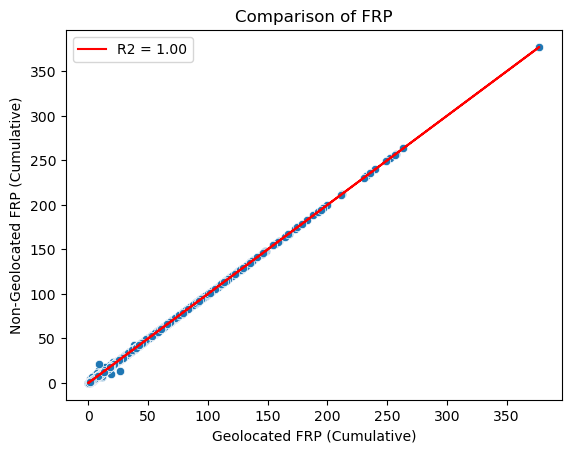

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Extract variables
x = comparison['frp_cumsum_geo']
y = comparison['frp_cumsum_ngeo']

# Scatter plot
sns.scatterplot(x=x, y=y)
plt.xlabel('Geolocated FRP (Cumulative)')
plt.ylabel('Non-Geolocated FRP (Cumulative)')
plt.title('Comparison of FRP')

# Add linear regression line
model = LinearRegression()
x_reshaped = x.values.reshape(-1, 1)
model.fit(x_reshaped, y)
plt.plot(x, model.predict(x_reshaped), color='red', label=f'R2 = {r2_score(y, model.predict(x_reshaped)):.2f}')
plt.legend()
plt.show()

In [ ]:
# Case 2: Greater than 50% overlap, same day, different time.

In [ ]:
time_threshold = timedelta(hours=2) # search for time within 3 hours

afds_ll_pix_c1 = afds_ll_pix_c1.reset_index()

drop_obs = set()
for acq_date, group in afds_ll_pix_c1.groupby('ACQ_DATE'):
    for dn in ['D','N']:
        dn_group = group[group['DAYNIGHT'] == dn].sort_values('ACQ_DATETIME')
        for idx, obs in dn_group.iterrows():
            time_matches = dn_group[
                (dn_group['ACQ_DATETIME'] > obs['ACQ_DATETIME']) &
                (dn_group['ACQ_DATETIME'] <= obs['ACQ_DATETIME'] + time_threshold) &
                (dn_group.index != idx)  # Exclude itself
            ]
            for match_idx, match_obs in time_matches.iterrows():
                # Calculate spatial overlap ratio
                overlap_area = obs.geometry.intersection(match_obs.geometry).area
                overlap_ratio = overlap_area / obs.geometry.area
                
                # Check for >50% spatial overlap
                if overlap_ratio > 0.50:
                    # Retain the highest FRP observation
                    if match_obs['FRP'] < obs['FRP']:
                        drop_obs.add(match_idx)

afds_ll_pix_c2 = afds_ll_pix_c2.drop(index=list(drop_obs)).reset_index(drop=True)
print(f"Identified a total of [{len(drop_obs)}/{len(afds_ll_pix_c1)}] overlapping observations within 2 hours, separated by day/night.")

In [ ]:
print(afds_srm_c2['FRP'].isna().sum())

In [ ]:
# Case 3: Classify first day of burn and secondary

In [ ]:
afds_srm_c2['detection'] = 'primary' # set the first day of burn / maximum FRP
afds_srm_c3 = afds_srm_c2.sort_values(['ACQ_DATETIME']).reset_index(drop=True)
afds_srm_c3 = afds_srm_c3.reset_index(drop=True)
afds_srm_c3.drop(columns=['index'], inplace=True)

overlap_gdf = gpd.sjoin(
    afds_srm_c3, 
    afds_srm_c3, 
    how="inner", 
    predicate="intersects", 
    lsuffix="left", 
    rsuffix="right")

# Iterate over each observation in swath_gdf_c3
for idx, obs in afds_srm_c3.iterrows():
    # Filter to previous overlapping observations only
    overlapping_obs = overlap_gdf[
        (overlap_gdf['afdID_left'] == obs['afdID']) &  # Current observation
        (overlap_gdf['afdID_right'] < obs['afdID']) &  # Previous observations only
        (overlap_gdf['DAYNIGHT_right'] == obs['DAYNIGHT'])  # Same day/night cycle
    ].copy()

    # Calculate overlap ratio for each overlapping observation
    overlap_ratios = [
        obs.geometry.intersection(afds_srm_c3.loc[afds_srm_c3['afdID'] == row['afdID_right']].geometry.iloc[0]).area
        / obs.geometry.area
        for _, row in overlapping_obs.iterrows()
    ]

    # Filter to those with significant overlap (e.g., >50%)
    overlapping_obs['overlap_ratio'] = overlap_ratios
    overlapping_obs = overlapping_obs[overlapping_obs['overlap_ratio'] > 0.5]

    # If there are overlapping observations, proceed to classify
    if not overlapping_obs.empty:
        max_frp = overlapping_obs['FRP_right'].max()  # Max FRP from overlapping observations

        # Classify based on FRP comparison
        if obs['FRP'] > max_frp:
            afds_srm_c3.at[idx, 'detection'] = 'flare-up'
        else:
            afds_srm_c3.at[idx, 'detection'] = 'secondary'

out_fp = os.path.join(projdir, 'data/spatial/mod/VIIRS/afd_aspen-fires_Case3.gpkg')
afds_srm_c3.to_file(out_fp)
print(f"Saved to: {out_fp}")

In [ ]:
print(afds_srm_c3['FRP'].isna().sum())

In [ ]:
afds_srm_c3['detection'].unique()

In [ ]:
# Plot FRP for each detection label
plt.figure(figsize=(5.5, 3))

sns.boxplot(data=afds_srm_c3, x='detection', y='log_FRP', palette="inferno")
plt.title("Distribution of log(FRP) by Detection Type")
plt.xlabel("Detection Type")
plt.ylabel("log(FRP)")

plt.savefig(os.path.join(projdir,'figures/FigureX_Primary_Secondary-FRP.png'), dpi=150, bbox_inches='tight')

plt.show()

In [ ]:
# Plot the distribution of "front" and "re-burn"
burn_class_counts = afds_srm_c3['detection'].value_counts()

# Plot a bar chart
plt.figure(figsize=(5, 3))
sns.barplot(x=burn_class_counts.index, y=burn_class_counts.values, palette="inferno")
plt.title("Primary, Secondary, and Flare-up Obs.")
plt.xlabel("Burn Class")
plt.ylabel("Count")

plt.savefig(os.path.join(projdir,'figures/FigureX_Primary_Secondary-Counts.png'), dpi=150, bbox_inches='tight')

plt.show()

In [ ]:
len(afds_srm_c3)

In [ ]:
# Join to CBI, TreeMap, etc

In [ ]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'data/tabular/mod/AFD/combined-afd_aspen-fires_TreeMap.csv')
treemap = pd.read_csv(fp)
treemap.drop(columns=["Unnamed: 0"], inplace=True)
print(len(treemap['afdID'].unique()))
treemap.head()

In [ ]:
# Identify "forested" VIIRS observations
# Calculate the total forest cover percent
pct_cover_sum = treemap.groupby('afdID')['pct_cover'].sum()
# Filter afdIDs with a sum of pct_cover greater than 50%
afdIDs_gt50 = pct_cover_sum[pct_cover_sum > 50].index

# Filter the original dataframe to keep only rows with these afdIDs
treemap_ = treemap[treemap['afdID'].isin(afdIDs_gt50)]
print(f"Number of afdIDs with pct_cover > 50%: {len(afdIDs_gt50)}")

In [ ]:
# Identify the dominant forest type
dtree = treemap_.loc[treemap_.groupby('afdID')['pct_cover'].idxmax()]
print(len(dtree))
dtree.head()

In [ ]:
dtree_frp = dtree.merge(afds_srm_c3, on='afdID', how='inner')
print(dtree_frp.columns)
len(dtree_frp)

In [ ]:
print(dtree_frp['FRP'].isna().sum())

In [ ]:
### Plot FRP by EVT group name
df = dtree_frp[dtree_frp['DAYNIGHT'] == 'D'] # primary obs.
df = dtree_frp

# Find the median and sort the evt classes
med = df.groupby('species_name')['FRP'].median().sort_values(ascending=False)
sorted = med.index.tolist()

plt.figure(figsize=(8, 8)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='species_name', 
    hue='detection',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.title('Daytime FRP by Detection Class and Species')
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Tree Species')

plt.tight_layout()

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-FRP-Detections.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
aspen_df = dtree_frp[dtree_frp['species_name'] == 'Aspen']
aspen_df = aspen_df[aspen_df['DAYNIGHT'] == 'D']

# Create the scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=aspen_df, x='FRP', y='BALIVE', hue='detection', style='detection', s=50, palette="viridis")
plt.xlabel('Aspen Live Basal Area')
plt.ylabel('FRP')
plt.legend(title='Detection Type')

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-Aspen-FRP_scatter.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Join in the CBI
cbi = os.path.join(projdir,'data/tabular/mod/AFD/combined-afd_aspen-fires_cbi.csv')
cbi = pd.read_csv(cbi)
cbi.columns

In [ ]:
cbi = cbi[['afdID','CBI_mean', 'CBI_bc_mean', 'rbr_mean']]
cbi.head()

In [ ]:
dtree_frp_cbi = dtree_frp.merge(cbi, on='afdID', how='inner')
print(len(dtree_frp_cbi))
dtree_frp_cbi.head()

In [ ]:
dtree_frp_cbi = dtree_frp_cbi.drop_duplicates(subset='afdID', keep='first')
len(dtree_frp_cbi)

In [ ]:
print(dtree_frp_cbi['afdID'].isna().sum())
print(dtree_frp_cbi['CBI_mean'].isna().sum())
print(dtree_frp_cbi['species_name'].isna().sum())
print(dtree_frp_cbi['FRP'].isna().sum())

In [ ]:
# Calculate the Pearson correlation by forest type

In [ ]:
df = dtree_frp_cbi[dtree_frp_cbi['detection'] == 'primary'] #primary obs.
df = dtree_frp_cbi[dtree_frp_cbi['DAYNIGHT'] == 'D'] #daytime

In [ ]:
from scipy.stats import pearsonr

correlations = {}
for tree_type, group in df.groupby('species_name'):
    corr, p_value = pearsonr(group['FRP'], group['CBI_bc_mean'])
    correlations[tree_type] = (corr, p_value)
    print(f"Tree Type: {tree_type} - Pearson correlation: {corr:.2f}, p-value: {p_value:.4f}")

In [ ]:
correlation_df = pd.DataFrame(correlations, index=['correlation', 'p_value']).T
print("\nCorrelation by Tree Type:\n")
correlation_df = correlation_df.sort_values('correlation')
correlation_df.to_csv(os.path.join(projdir, 'data/tabular/mod/afds_aspen-fires_frp-cbi_pearson.csv'))
correlation_df.head(15)

In [ ]:
g = sns.lmplot(data=df, x='FRP', y='CBI_bc_mean', hue='species_name', col='species_name', 
           col_wrap=3, height=2, aspect=1.5, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, sharey=True
          )

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    ax.set_ylim(0, 4)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('species_name = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-FRP-CBI_bc.png'), dpi=300, bbox_inches='tight')

plt.show()